In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from numpy.random import randn
np.random.seed(0)
import pickle
import gzip
from sklearn.preprocessing import MinMaxScaler
from sklearn import decomposition
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from geopy.distance import great_circle

In [4]:
# data loading

# NOISE
with gzip.open('../data/segment_with_noise_v2/ll_seg_500_noise_v2.pkl.gzip', 'rb') as f:
    ll_seg_noise = pickle.load(f)
with gzip.open('../data/segment_with_noise_v2/rl_seg_500_noise_v2.pkl.gzip', 'rb') as f:
    rl_seg_noise = pickle.load(f)

# GROUND TRUTH
with gzip.open('../data/segment_groud_truth/rl_seg_gt_500.pkl.gzip', 'rb') as f:
    ll_seg_gps_gt = pickle.load(f)
with gzip.open('../data/segment_groud_truth/ll_seg_gt_500.pkl.gzip', 'rb') as f:
    rl_seg_gps_gt = pickle.load(f)

print(len(ll_seg_noise))
print(ll_seg_noise[0].shape[0])
ll_seg_noise[0].head()

500
153


,y,x,y_norm,x_norm,Vy_norm,Vx_norm,theta_norm,psi_norm,phi_norm,omega_Xv_norm,omega_Yv_norm,alpha_Xv_norm,alpha_Yv_norm,lane,y_norm_noise,x_norm_noise
43567,42.246179,-83.563086,0.786530,0.206384,0.764706,0.778120,0.659098,0.423909,0.453957,0.466896,0.411583,0.508045,0.593818,1,0.786883,0.206219
43592,42.246173,-83.563099,0.785916,0.205506,0.705882,0.775039,0.659040,0.433179,0.453350,0.377472,0.481081,0.481543,0.542299,1,0.785997,0.205486
43617,42.246167,-83.563112,0.785304,0.204631,0.764706,0.771957,0.658926,0.425454,0.448492,0.418745,0.388417,0.478467,0.536334,1,0.785500,0.204498
43642,42.246161,-83.563125,0.784696,0.203759,0.764706,0.767334,0.658862,0.432599,0.459826,0.508169,0.498842,0.510648,0.532267,1,0.785144,0.203984
43667,42.246155,-83.563137,0.784089,0.202890,0.764706,0.764253,0.658731,0.431827,0.465695,0.474635,0.473359,0.473024,0.564262,1,0.784462,0.202674


In [8]:
# example segment
exp_rl_seg_noise = ll_seg_noise[91]
print(exp_rl_seg_noise.shape)

(153, 16)


In [9]:
exp_rl_seg_noise.head()

,y,x,y_norm,x_norm,Vy_norm,Vx_norm,theta_norm,psi_norm,phi_norm,omega_Xv_norm,omega_Yv_norm,alpha_Xv_norm,alpha_Yv_norm,lane,y_norm_noise,x_norm_noise
21752,42.246163,-83.551625,0.784951,0.987688,0.588235,0.779661,0.990650,0.877752,0.460231,0.494411,0.415444,0.621865,0.549620,1,0.784921,0.987621
21777,42.246175,-83.551626,0.786100,0.987625,0.588235,0.782743,0.990425,0.872731,0.468933,0.456578,0.522780,0.610506,0.554772,1,0.786229,0.987435
21802,42.246186,-83.551627,0.787251,0.987559,0.588235,0.784284,0.989972,0.878138,0.469338,0.427343,0.514286,0.623284,0.552603,1,0.787260,0.987523
21827,42.246198,-83.551628,0.788407,0.987491,0.529412,0.785824,0.989547,0.879490,0.463064,0.486672,0.474903,0.607903,0.548265,1,0.788534,0.987065
21852,42.246209,-83.551629,0.789565,0.987419,0.588235,0.788906,0.989108,0.883353,0.466707,0.463457,0.528185,0.631093,0.568872,1,0.789452,0.987495


In [10]:
# normalize time for calculating dt

t_norm = MinMaxScaler().fit_transform(np.linspace(0, exp_rl_seg_noise.shape[0] * 50 * 0.01, num=exp_rl_seg_noise.shape[0]).reshape(-1,1)).flatten()
dt = t_norm[1] - t_norm[0]
dt

0.006578947368421052

## linear kalman filter design

In [16]:
x_noise = exp_rl_seg_noise['x_norm_noise'].values
y_noise = exp_rl_seg_noise['y_norm_noise'].values
Vx = exp_rl_seg_noise['Vx_norm'].values
Vy = exp_rl_seg_noise['Vy_norm'].values
alpha_Xv = exp_rl_seg_noise['alpha_Xv_norm'].values
alpha_Yv = exp_rl_seg_noise['alpha_Yv_norm'].values

gps_sig = 0.005
# dt = (exp_ll_seg_gps_noise.index[2] - exp_ll_seg_gps_noise.index[1]) * 0.01
d3xdt3 = np.gradient(exp_rl_seg_noise['alpha_Xv_norm'], dt)
d3ydt3 = np.gradient(exp_rl_seg_noise['alpha_Yv_norm'], dt)

A = np.array([
    [1, dt, (dt**2)/2, 0, 0, 0],
    [0, 1, dt, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, dt, (dt**2)/2],
    [0, 0, 0, 0, 1, dt],
    [0, 0, 0, 0, 0, 1],
    ])

Q1 = np.array([(dt**3)/6, (dt**2)/2, dt, 0, 0, 0])
Q1 = np.expand_dims(Q1, 1)
Q2 = np.array([0, 0, 0, (dt**3)/6, (dt**2)/2, dt])
Q2 = np.expand_dims(Q2, 1)

j_var = max(np.var(d3xdt3), np.var(d3ydt3))
Q = j_var * (Q1 @ Q1.T + Q2 @ Q2.T)

H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    ])

R = np.diag(np.array([gps_sig**2, gps_sig**2]))

x_init = np.array([x_noise[0], Vx[0], alpha_Xv[0], y_noise[0], Vy[0], alpha_Yv[0]])
P_init = 0.001 * np.eye(len(x_init))  # small initial prediction error

In [17]:
# create an observation vector of noisy GPS signals
observations = np.array([x_noise, y_noise]).T

# matrix dimensions, nxm
nx = Q.shape[0]
ny = R.shape[0]     
nt = observations.shape[0]

# allocate identity matrix for re-use
Inx = np.eye(nx)

# allocate result matrices
x_pred = np.zeros((nt, nx))      # prediction of state vector
P_pred = np.zeros((nt, nx, nx))  # prediction error covariance matrix
x_est = np.zeros((nt, nx))       # estimation of state vector
P_est = np.zeros((nt, nx, nx))   # estimation error covariance matrix
K = np.zeros((nt, nx, ny))       # Kalman Gain

# set initial prediction
x_pred[0] = x_init
P_pred[0] = P_init

for i in range(nt):

    # prediction stage
    if i > 0:
        x_pred[i] = A @ x_est[i-1]
        P_pred[i] = A @ P_est[i-1] @ A.T + Q

    # estimation stage
    y_obs = observations[i]
    K[i] = P_pred[i] @ H.T @ np.linalg.inv((H @ P_pred[i] @ H.T) + R)
    x_est[i] = x_pred[i] + K[i] @ (y_obs - H @ x_pred[i])
    P_est[i] = (Inx - K[i] @ H) @ P_pred[i]

In [52]:
def kf(segment_df):

    # states
    x_noise = segment_df['x_norm_noise'].values
    y_noise = segment_df['y_norm_noise'].values
    Vx = segment_df['Vx_norm'].values
    Vy = segment_df['Vy_norm'].values
    alpha_Xv = segment_df['alpha_Xv_norm'].values
    alpha_Yv = segment_df['alpha_Yv_norm'].values
    d3xdt3 = np.gradient(exp_rl_seg_noise['alpha_Xv_norm'], dt)
    d3ydt3 = np.gradient(exp_rl_seg_noise['alpha_Yv_norm'], dt)

    gps_sig = 0.0002

    # initialization
    A = np.array([
        [1, dt, (dt**2)/2, 0, 0, 0],
        [0, 1, dt, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, dt, (dt**2)/2],
        [0, 0, 0, 0, 1, dt],
        [0, 0, 0, 0, 0, 1],
        ])

    H = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        ])

    Q1 = np.array([(dt**3)/6, (dt**2)/2, dt, 0, 0, 0])
    Q1 = np.expand_dims(Q1, 1)
    Q2 = np.array([0, 0, 0, (dt**3)/6, (dt**2)/2, dt])
    Q2 = np.expand_dims(Q2, 1)

    j_var = max(np.var(d3xdt3), np.var(d3ydt3))
    Q = j_var * (Q1 @ Q1.T + Q2 @ Q2.T)
    R = np.diag(np.array([gps_sig**2, gps_sig**2]))

    x_init = np.array([x_noise[0], Vx[0], alpha_Xv[0], y_noise[0], Vy[0], alpha_Yv[0]])
    P_init = 1 * np.eye(len(x_init))  # small initial prediction error

    # create an observation vector of noisy GPS signals
    observations = np.array([x_noise, y_noise]).T

    # matrix dimensions, nxm
    nx = Q.shape[0]
    ny = R.shape[0]     
    nt = observations.shape[0]

    # allocate identity matrix for re-use
    Inx = np.eye(nx)

    # allocate result matrices
    x_pred = np.zeros((nt, nx))      # prediction of state vector
    P_pred = np.zeros((nt, nx, nx))  # prediction error covariance matrix
    x_est = np.zeros((nt, nx))       # estimation of state vector
    P_est = np.zeros((nt, nx, nx))   # estimation error covariance matrix
    K = np.zeros((nt, nx, ny))       # Kalman Gain

    # set initial prediction
    x_pred[0] = x_init
    P_pred[0] = P_init

    for i in range(nt):

        # prediction stage
        if i > 0:
            x_pred[i] = A @ x_est[i-1]
            P_pred[i] = A @ P_est[i-1] @ A.T + Q

        # estimation stage
        y_obs = observations[i]
        K[i] = P_pred[i] @ H.T @ np.linalg.inv((H @ P_pred[i] @ H.T) + R)
        x_est[i] = x_pred[i] + K[i] @ (y_obs - H @ x_pred[i])
        P_est[i] = (Inx - K[i] @ H) @ P_pred[i]
    
    return x_est, x_noise, y_noise, segment_df['x_norm'].values, segment_df['y_norm'].values

## batch estimation

In [58]:
x_noise = exp_rl_seg_noise['x_norm_noise'].values
y_noise = exp_rl_seg_noise['y_norm_noise'].values

x_est_sample, x_noise, y_noise, x, y  = kf(exp_rl_seg_noise)

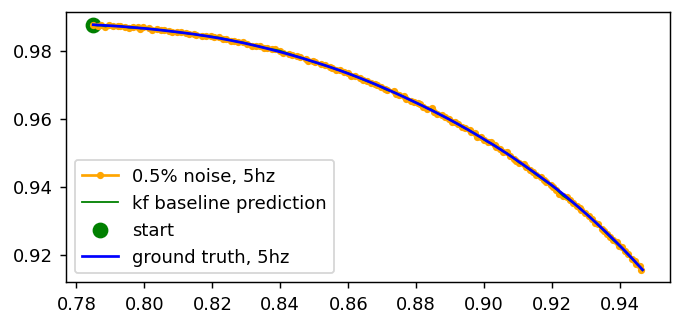

In [59]:
plt.figure(dpi=130, figsize=(6, 2.75))

plt.plot(y_noise, x_noise, '-o', label='0.5% noise, 5hz', ms=3, c='orange')
plt.plot(x_est_sample[:, 3], x_est_sample[:, 0], '-', linewidth=1, label='kf baseline prediction', c='green')
plt.scatter(x_est_sample[:, 3][0], x_est_sample[:, 0][0], label='start', s=60, c='green')
plt.plot(exp_rl_seg_noise['y_norm'].values, exp_rl_seg_noise['x_norm'].values, label='ground truth, 5hz', c='blue')

plt.legend()

In [60]:
rl_seg_pred = []

for df in rl_seg_noise:
    x_est_sample, x_noise, y_noise, x, y = kf(df)
    x_est_df = pd.DataFrame(
        {'x_est': x_est_sample[:, 0],
        'y_est': x_est_sample[:, 3],
        'x_noise': x_noise,
        'y_noise': y_noise,
        'x': x,
        'y': y
        }
    )
    rl_seg_pred.append(x_est_df)    

In [61]:
rl_seg_pred[0]

,x_est,y_est,x_noise,y_noise,x,y
0,0.206219,0.786883,0.206219,0.786883,0.206384,0.786530
1,0.205492,0.786002,0.205486,0.785997,0.205506,0.785916
2,0.204547,0.785442,0.204498,0.785500,0.204631,0.785304
3,0.203907,0.785044,0.203984,0.785144,0.203759,0.784696
4,0.202859,0.784492,0.202674,0.784462,0.202890,0.784089
...,...,...,...,...,...,...
148,0.087358,0.686453,0.087649,0.686148,0.087317,0.686411
149,0.086508,0.685558,0.086469,0.685474,0.086492,0.685567
150,0.085628,0.684702,0.085539,0.684712,0.085675,0.684726
151,0.084863,0.683978,0.084996,0.684229,0.084863,0.683887


In [64]:
x_max = -83.55144472
y_max = 42.24829894
x_min = -83.56611364
y_min = 42.23836889

y_exp_pred_scale = []
y_exp_gt_scale = []
y_exp_noise_scale = []


def inv_normalize(y, x):
    y_scale = y * (y_max - y_min) + y_min
    x_scale = x * (x_max - x_min) + x_min
    coord_scale = np.append(
        y_scale.reshape(153, 1), x_scale.reshape(153, 1), axis=1
    )
    return coord_scale


# estimation
for df in rl_seg_pred:

    coord_scale_pred = inv_normalize(df['y_est'].values, df['x_est'].values)
    coord_scale_gt = inv_normalize(df['y'].values, df['x'].values)
    coord_scale_noise = inv_normalize(df['y_noise'].values, df['x_noise'].values)

    y_exp_pred_scale.append(coord_scale_pred)
    y_exp_gt_scale.append(coord_scale_gt)
    y_exp_noise_scale.append(coord_scale_noise)

y_pred_scale = np.asarray(y_exp_pred_scale)
y_gt_scale = np.asarray(y_exp_gt_scale)
y_exp_noise_scale = np.asarray(y_exp_noise_scale)

great_circie_err = []
great_circie_noise_err = []

for i in np.arange(len(rl_seg_pred)):
    for traj_i in np.arange(153):
        pred_coord = (y_pred_scale[i][traj_i][0], y_pred_scale[i][traj_i][1])
        actual_coord = (y_gt_scale[i][traj_i][0], y_gt_scale[i][traj_i][1])
        noise_coord = (y_exp_noise_scale[i][traj_i][0], y_exp_noise_scale[i][traj_i][1])

        great_circie_err.append(great_circle(pred_coord, actual_coord).miles * 1609.34) # meter
        great_circie_noise_err.append(great_circle(noise_coord, actual_coord).miles * 1609.34) # meter

In [46]:
x_max = -83.55144472
y_max = 42.24829894
x_min = -83.56611364
y_min = 42.23836889

y_exp_test_scale = []
y_exp_noise_scale = []
y_exp_pred_scale = []

# estimation
y_scale = x_est_sample[:, 3] * (y_max - y_min) + y_min
x_scale = x_est_sample[:, 0] * (x_max - x_min) + x_min

coord_scale = np.append(
    y_scale.reshape(153, 1), x_scale.reshape(153, 1), axis=1
)
y_exp_pred_scale.append(coord_scale)

# gt
y_scale = exp_rl_seg_noise['y_norm'].values * (y_max - y_min) + y_min
x_scale = exp_rl_seg_noise['x_norm'].values * (x_max - x_min) + x_min
coord_scale = np.append(
    y_scale.reshape(153, 1), x_scale.reshape(153, 1), axis=1
)
y_exp_test_scale.append(coord_scale)

# noise
y_scale = y_noise * (y_max - y_min) + y_min
x_scale = x_noise * (x_max - x_min) + x_min
coord_scale = np.append(
    y_scale.reshape(153, 1), x_scale.reshape(153, 1), axis=1
)
y_exp_noise_scale.append(coord_scale)

y_test_scale = np.asarray(y_exp_test_scale)
y_pred_scale = np.asarray(y_exp_pred_scale)
y_exp_noise_scale = np.asarray(y_exp_noise_scale)

great_circie_err = []
great_circie_noise_err = []

for traj_i in np.arange(153):
    pred_coord = (y_pred_scale[0][traj_i][0], y_pred_scale[0][traj_i][1])
    actual_coord = (y_test_scale[0][traj_i][0], y_test_scale[0][traj_i][1])
    noise_coord = (y_exp_noise_scale[0][traj_i][0], y_exp_noise_scale[0][traj_i][1])

    great_circie_err.append(great_circle(pred_coord, actual_coord).miles * 1609.34) # meter
    great_circie_noise_err.append(great_circle(noise_coord, actual_coord).miles * 1609.34) # meter

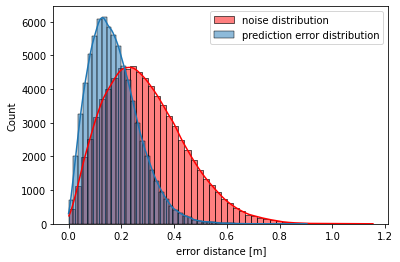

In [82]:
ax = sns.histplot(
    great_circie_noise_err, 
    bins=50, label='noise distribution', color='red', kde=True)
sns.histplot(
    great_circie_err, 
    bins=50, label='prediction error distribution', kde=True)

plt.xlabel('error distance [m]')
plt.legend()

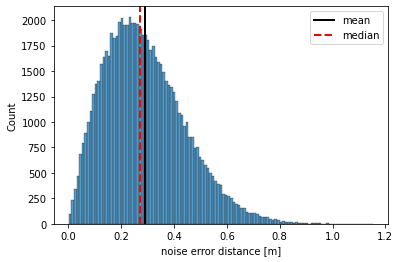

In [65]:
ax = sns.histplot(great_circie_noise_err)
ax.axvline(np.average(great_circie_noise_err), color='k', lw=2, label='mean')
ax.axvline(np.median(great_circie_noise_err), color='red', ls='--', lw=2, label='median')
plt.xlabel('noise error distance [m]')
plt.legend()

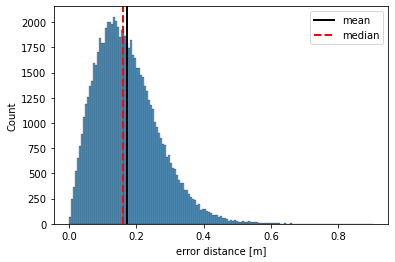

In [66]:
ax = sns.histplot(great_circie_err)
ax.axvline(np.average(great_circie_err), color='k', lw=2, label='mean')
ax.axvline(np.median(great_circie_err), color='red', ls='--', lw=2, label='median')
plt.xlabel('error distance [m]')
plt.legend()

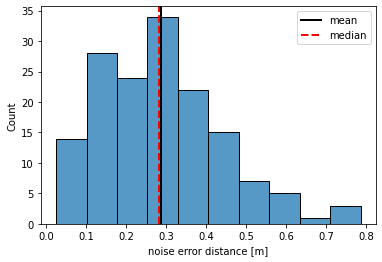

In [47]:
ax = sns.histplot(great_circie_noise_err)
ax.axvline(np.average(great_circie_noise_err), color='k', lw=2, label='mean')
ax.axvline(np.median(great_circie_noise_err), color='red', ls='--', lw=2, label='median')
plt.xlabel('noise error distance [m]')
plt.legend()

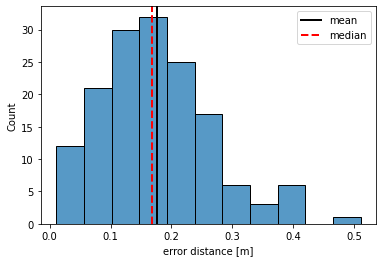

In [48]:
ax = sns.histplot(great_circie_err)
ax.axvline(np.average(great_circie_err), color='k', lw=2, label='mean')
ax.axvline(np.median(great_circie_err), color='red', ls='--', lw=2, label='median')
plt.xlabel('error distance [m]')
plt.legend()

In [10]:
noise = np.random.normal(0, 1, size=(1000, 2)) * 0.0001
noise[:,0] = noise[:,0] * (x_max - x_min) + x_min
noise[:,1] = noise[:,1] * (y_max - y_min) + y_min
noise = list(zip(noise[:,0], noise[:,1]))

zeros = np.zeros((1000, 2))
zeros[:,0] = zeros[:,0] * (x_max - x_min) + x_min
zeros[:,1] = zeros[:,1] * (y_max - y_min) + y_min
zeros = list(zip(zeros[:,0], zeros[:,1]))

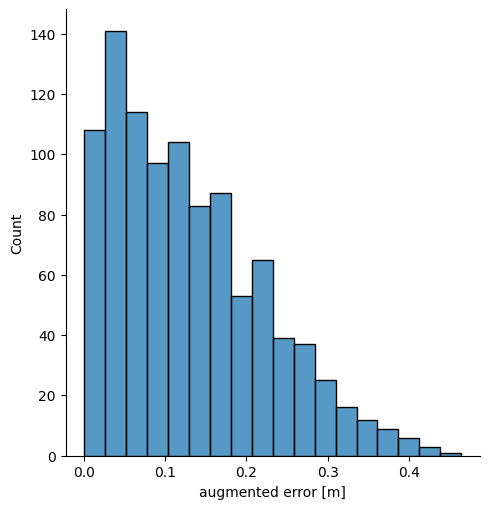

In [11]:
# augmented noise distribution in meters

distances = [great_circle(noise[i], zeros[i]).miles * 1609.34 for i in np.arange(1000)]
sns.displot(distances)
plt.xlabel('augmented error [m]')
plt.show()